### 背景

　　　随着信息技术的飞速发展，电信网络诈骗已成为全球范围内一个日益严重的问题。诈骗分子利用各种手段，如电话、短信、社交媒体、电子邮件等，针对个人和企业实施诈骗活动。这些诈骗活动不仅给受害者造成了巨大的经济损失，还对社会治安和个人隐私安全带来了严重的威胁。

　　　近年来，电信网络诈骗案件频发，诈骗手法层出不穷，包括但不限于冒充公检法机关、假冒熟人、虚假购物网站、投资诈骗等。诈骗分子利用技术手段伪装身份，使得传统的防范措施难以应对。同时，随着移动支付和在线金融服务的普及，诈骗分子更加容易获得受害者的财产信息，进一步加剧了损失的风险。

目前，虽然政府和相关机构采取了一系列措施来打击电信网络诈骗，但在实际操作过程中仍存在不少挑战，如：

- **信息不对称**：普通民众缺乏必要的防骗知识，难以识别诈骗行为。
- **技术滞后**：传统的反诈手段往往落后于诈骗分子的技术手段。
- **反应迟缓**：在诈骗发生后，相关部门往往无法及时采取有效措施，导致损失扩大。

### 目标

本项目旨在开发一套基于人工智能技术的“智侦反诈分类引擎”，以提高电信网络诈骗的识别准确率和响应速度。具体目标包括：

- **高效识别**：通过对大量历史诈骗案例的学习，建立高效的识别模型，能够自动识别出潜在的诈骗信息。
- **持续更新**：随着诈骗手法的变化，系统需要具备自我学习的能力，不断优化识别模型，提高识别准确性。
- **跨部门合作**：促进政府、企业和公众之间的合作，形成合力，共同打击电信网络诈骗。
- **法律支持**：为相关部门提供技术支撑，协助制定和完善相关法律法规，增强法律执行力。


### 数据说明

　**fraud_data.csv**数据主要包含**ID、案件编号、案情描述和案件类别**维度，约有**8万余条**数据，其中“**案情描述**”字段为我们首要处理使用的字段，其中包含了电信诈骗案件的详细信息，将使用此描述对其进行智能识别分类。

**数据**

- **数据样例**

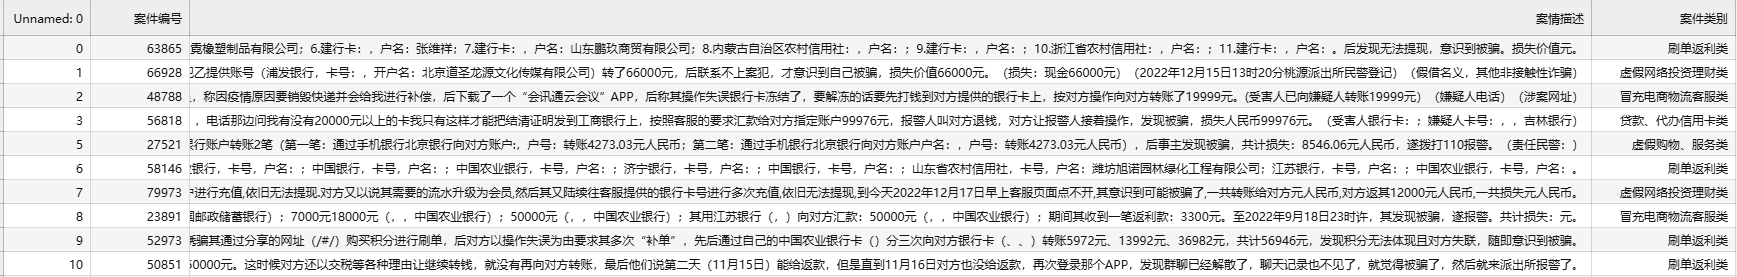

- **字段解读**

| 字段名称     | 字段说明                         |
| ------------ | -------------------------------- |
| id | 唯一编号 |
| 案件编号 | 案件的编号 |
| 案情描述 | 具体案情的详细描述，长文本 |
| 案件类别 | 电信诈骗案件的类别 |

### 分析思路

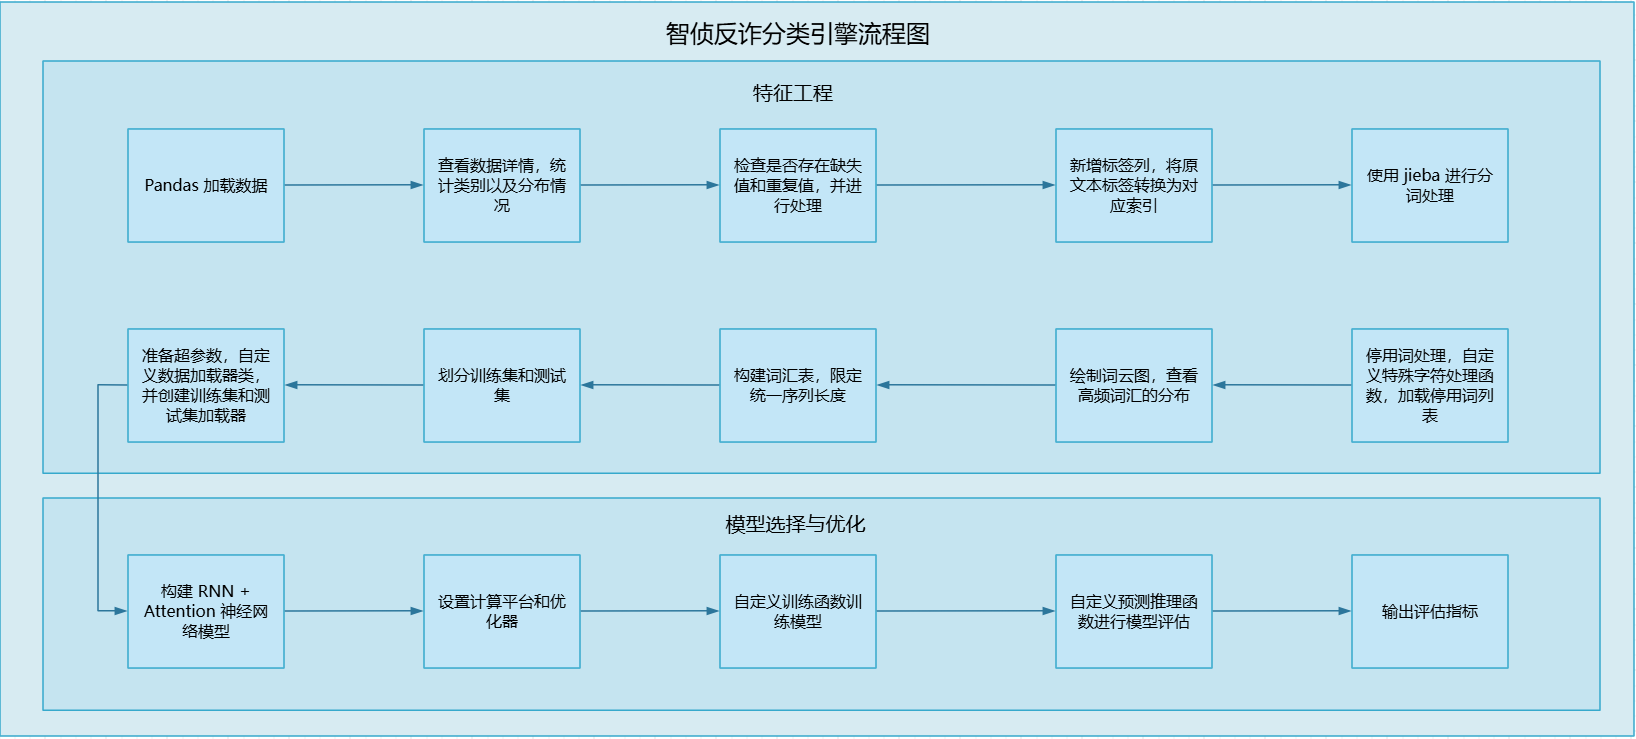

#### 1.数据探索与预处理
　　对数据进行统计分析，理解数据的基本特征和结构，检测数据中的缺失值和重复值并进行清洗，保证数据规范性。</br>
#### 2.文本数据处理
　　将类别标签进行索引化；对案情描述文本进行 jieba 分词处理，获取单词表；加载停用词表，自定义处理文本中特殊字符和数值的函数，去除文本的噪声，绘制词云图图，查看高频词汇。</br>
#### 3.特征工程
　　自定义函数实现统一词典和文本序列映射为固定长度的序列，进行填充或截断处理；划分数据集为训练集和测试集，并转换数据类型，准备模型的输入。</br>
#### 4.模型配置
　　设定模型训练所需的超参数（如学习率、批量大小等）；自定义数据集加载类，创建训练集和测试集的数据加载器。</br>
#### 5.模型训练
　　选择计算平台GPU/CPU（如有GPU情况下优先选择GPU）；设置模型优化器，确定更新参数的策略；训练模型。
#### 6.模型评估
  　在测试集上进行预测推理，计算评估模型指标。

In [1]:
import pandas as pd
import jieba
import re
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from wordcloud import WordCloud

import warnings

# 在Jupyter中内联显示图形
%matplotlib inline
# 设置中文显示字体为SimHei
plt.rcParams['font.sans-serif'] = 'SimHei'
# 解决负号'-'等特殊符号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 使用ggplot样式来绘制图形
plt.style.use('ggplot')
# 忽略警告信息，以免干扰代码执行过程
warnings.filterwarnings('ignore')

### 数据探索与预处理

1.读取数据</br>
2.查看数据详情与类型</br>
3.查看标签类别分布情况</br>
4.检查缺失值与处理</br>
5.检查重复值与处理</br>
6.转换类别标签列为数值索引

#### 读取数据

<font size=3 color=#0000dd>考点1：使用`pandas`读取“/home/qingjiao/TelecomFraudProject/data/”目录下的电信诈骗数据文件（注意停用词和模型权重也在相应目录下），查看前 10 行数据。</font>

In [2]:
# 数据资源路径
data_path = './data/fraud_data.csv' # 训练集数据
stopwords_path = './stopwords/stopwords.txt' # 停用词
model_weights = './weights/model_weights.pth' # 权重位置

In [3]:
#读取数据
data = pd.read_csv(data_path, encoding='UTF-8') #读取csv数据文件，编码格式为utf-8
data.head(10) # 查看前 10 行

,Unnamed: 0,案件编号,案情描述,案件类别
0,0,63865,2022年12月7日，（微信号：；农行卡：；建行卡：；中行卡；邮储卡：）在家中添加了一个微信...,刷单返利类
1,1,66928,2022年12月15日，报案人向110报警称：2021年3月8日21时00分至2022年10...,虚假网络投资理财类
2,2,48788,2022年111月11日，接报警称其在家中，于当天晚上18时左右接到陌生电话对方自称时快递客...,冒充电商物流客服类
3,3,56818,2022年11月28日16时30分至2022年11月28日17时40分，报警人在里，因房子贷...,贷款、代办信用卡类
4,5,27521,2022年09月03日11时09分许，事主（身份证：，现住地：，户籍所在地）拨打110报警称...,虚假购物、服务类
5,6,58146,2022年11月30日，(男，证件类型居民身份证，证件号码，汉族，政治面貌群众，大学专科毕业...,刷单返利类
6,7,79973,"2022年12月17日23时04分许，被害人（27岁,群众,汉族,大专)来福强派出所报警称：...",虚假网络投资理财类
7,8,23891,2022年9月18日12时许，（女，，现住：，联系方式：）在家中，收到超值教育平台的短信：称...,冒充电商物流客服类
8,9,52973,2022年11月18日13时至15时许，受害人在家中玩手机时，通过微信群内发送的网址链接（）...,刷单返利类
9,10,50851,2022年11月16日，报警称被电信诈骗约12万元。经民警询问得知，2022年11月14日，...,刷单返利类


#### 查看数据详情与类型

<font size=3 color=#0000dd>考点2：使用`pandas`一个函数查看数据详情。</font>

In [4]:
# 查看数据详细信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77331 entries, 0 to 77330
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  77331 non-null  int64 
 1   案件编号        77331 non-null  int64 
 2   案情描述        77331 non-null  object
 3   案件类别        77331 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.4+ MB


<font size=3 color=#0000dd>考点3：对“案件类别”进行去重，统计总类别数。</font>

In [5]:
#查看有多少不同的类
label = list(data['案件类别'].unique())
# 计算出类别数（而不是sum）
num_category = len(label)
print(label, " 总类别数：", num_category) # 打印标签类别

['刷单返利类', '虚假网络投资理财类', '冒充电商物流客服类', '贷款、代办信用卡类', '虚假购物、服务类', '冒充公检法及政府机关类', '虚假征信类', '冒充领导、熟人类']  总类别数： 8


#### 统计类别标签的分布情况

<font size=3 color=#0000dd>考点4：统计各“案件类别”的分布情况。</font>

In [6]:
data.groupby(['案件类别']).size() # 查看案件类别的分布

案件类别
冒充公检法及政府机关类     3651
冒充电商物流客服类      11018
冒充领导、熟人类        3525
刷单返利类          28367
虚假征信类           6771
虚假网络投资理财类       9469
虚假购物、服务类        5647
贷款、代办信用卡类       8883
dtype: int64

#### 检查缺失值并处理

<font size=3 color=#0000dd>考点5：检查 “案情描述” 中是否存在缺失值，如果存在缺失值则删除，并输出缺失值数量。</font>

In [ ]:
# 检查 “案情描述” 列的缺失值数量
missing_values = data['案情描述'].isnull().sum()
# 输出缺失值的行数（非零行）
missing_rows = missing_values[missing_values > 0]

# print("缺失值数量:", missing_rows.size) # 也可以
print("缺失值数量:", missing_rows.shape[0])

缺失值数量: 0


#### 检查重复值并处理

<font size=3 color=#0000dd>考点6：检查 “案情描述” 中是否存在重复值，如果存在重复值则删除，并输出重复值数量。</font>

In [8]:
# 检查 “案情描述” 列是否存在重复值
duplicate_rows = data['案情描述'].duplicated().sum()

print("重复值数量:", duplicate_rows)

重复值数量: 29


In [9]:
# 删除重复值
data.drop_duplicates(subset=['案情描述'], keep='first', inplace=True)

### 文本数据处理

1.类别标签数值索引化</br>
2.jieba 分词处理</br>
3.停用词处理</br>
4.高频词可视化

#### 类别标签数值化

<font size=3 color=#0000dd>考点7：将 “案件类别” 标签列映射为数值索引，并输出标签数量。</font>

In [10]:
# 增添标签列
def label_dataset(row):  
    num_label = label.index(row) #提取label的索引 
    return num_label  
  
data['label'] = data['案件类别'].apply(label_dataset) # 根据 “案件类别” 索引生成类别标签
labels = data['label'].tolist() # 转换为 List 列表

# 查看标签数量
print("标签数量：",len(labels))

标签数量： 77302


#### jieba 分词

<font size=3 color=#0000dd>考点8：使用 jieba 库完成对文本的分词，封装为函数。</font>

In [11]:
# 定义中文分词函数  
def chinese_word_cut(row):
    # 先进行结巴分词
    return list(jieba.lcut(row))  # 返回分词结果的列表

#### 停用词处理
- **1.自定义加载停用词函数**
- **2.自定义去除特殊字符和数的函数**

<font size=3 color=#0000dd>考点9：自定义加载停用词列表、去除特殊字符和数值和去除停用词的函数。</font>

In [12]:
# 实现加载停用词列表函数
def load_stopwords_list(filepath):
    stopwords = []
    with open(filepath, 'r', encoding='utf-8') as reader_stream:
        for line in reader_stream:
            stopwords.append(line.strip())  # 去掉行末的换行符
    return stopwords

# 去除特殊符号和数值的函数
def remove_punctuation(line):
    text_line = str(line)
    if text_line.strip() == '':
        return ''
    text_line = re.sub(r'\d+', '', text_line)  # 去除每条句子中的数值
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")  # 根据定义的规则去除无用符号
    text_line = rule.sub('', text_line)
    return text_line

# 去除停用词的函数
def remove_stopwords(tokenized_texts, stopwords):
    return [word for word in tokenized_texts if word not in stopwords and word]  # 过滤掉停用词和空字符串

<font size=3 color=#0000dd>考点10：调用分词、停用词和特殊字符处理函数，获取处理后列表。</font>

In [13]:
# 应用函数实现中文分词并将其转换为列表
tokenized_texts = data['案情描述'].apply(chinese_word_cut).tolist()  # 对每行进行分词

# 加载停用词列表
stopwords = load_stopwords_list(stopwords_path)

# 去除特殊符号并处理停用词
cleaned_texts = []
for tokens in tokenized_texts:
    tokens = [remove_punctuation(token) for token in tokens]  # 去除标点
    cleaned_tokens = remove_stopwords(tokens, stopwords)  # 去除停用词
    cleaned_texts.append(cleaned_tokens)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.791 seconds.
Prefix dict has been built successfully.


In [14]:
print("经分词和停用词后的词表：", cleaned_texts[:5]) # 输出经过分词和停用词后的 5 个词表

经分词和停用词后的词表： [['微', '信号', '农行', '卡', '建行', '卡', '中行', '卡', '邮储', '卡', '家中', '添加', '一个', '微信', '好友', '微', '信号', '录入', '一个', '微信', '刷', '单群', '解散', '群内', '指示', '下载', '乐橙', 'APP', 'APP', '发现', '板块', '进行', '做', '任务', '刷单', '多次', '银行卡', '转账', '账户', '农行', '卡', '户名', '中行', '卡', '户名', '建行', '卡', '户名', '户名', '广西', '益城', '房地产', '代理', '有限公司', '农行', '卡', '户名', '衡水', '霓', '橡', '塑制品', '有限公司', '建行', '卡', '户名', '张维祥', '建行', '卡', '户名', '山东', '鹏', '玖', '商贸', '有限公司', '内蒙古自治区', '农村', '信用社', '户名', '建行', '卡', '户名', '浙江省', '农村', '信用社', '户名', '建行', '卡', '户名', '发现', '无法', '提现', '意识', '骗', '损失', '价值', '元'], ['报案人', '报警', '称', '分至', '之间', '微信', '昵称', '帅', '认识', '案犯', '甲', '微信', '昵称', '案犯', '甲', '自称', '股票', '行业', '专家', '拉', '进微', '信群', '群名', '期老杜', '慈善', '交流学习', '群', '案犯', '甲', '群里', '称', '投资', '电影', '赚钱', '推荐', '案犯', '乙', '微信', '昵称', '小林', '案犯', '乙称', '认购', '电影', '投资', '收益权', '获得', '收益', '信以为真', '中国银行', '卡号', '开户名', '网银', '转账', '方式', '案犯', '乙', '提供', '账号', '浦发银行', '卡号', '开户名', '北京', '道', '圣龙源', '文化传媒', '有限公司', '

#### 绘制词汇分布的词云图

<font size=3 color=#0000dd>考点11：使用 WordCloud 库绘制最高出现次数的前 50 个词的词云图。</font>

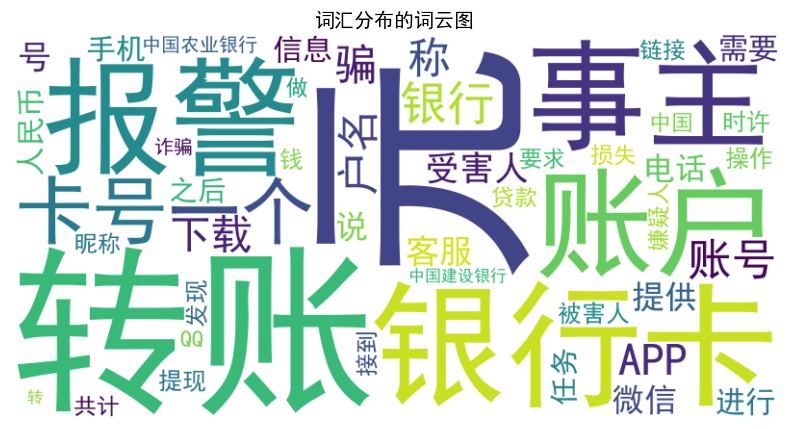

In [15]:
# 统计词频
all_words = [word for tokens in cleaned_texts for word in tokens]  # 扁平化
word_counts = Counter(all_words)  # 统计每个词的频率
most_common_words = dict(word_counts.most_common(50))  # 获取前50个高频词（注意按照题目来）

# 绘制词云图
wordcloud = WordCloud(font_path='/usr/share/fonts/chinese/SimHei.ttf',  # 需要提供中文字体的路径
                      width=800,
                      height=400,
                      background_color='white').generate_from_frequencies(most_common_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不显示坐标轴
plt.title('词汇分布的词云图')
plt.show()

### 特征工程

1.构建词典</br>
2.序列映射</br>
3.划分数据集</br>
4.转换数据类型

#### 构建词典，统一序列长度

<font size=3 color=#0000dd>考点12：自定义函数 build_vocab_and_sequences ，实现生成文档词典和统一词向量序列的长度。</font>

In [16]:
# 自定义函数来构建词表和填充序列
def build_vocab_and_sequences(tokenized_texts):
    # 扁平化列表以收集所有词
    flat_list = [word for sublist in tokenized_texts for word in sublist]
    
    # 生成词汇表，包含所有唯一词汇
    vocab = {word: idx + 1 for idx, word in enumerate(set(flat_list))}
    vocab['<PAD>'] = 0  # 添加填充标记

    # 将词语转换为整数索引
    sequences = [[vocab.get(word, vocab['<PAD>']) for word in text] for text in tokenized_texts]

    # 计算序列的均值长度
    lengths = [len(seq) for seq in sequences]
    mean_length = int(sum(lengths) / len(lengths)) if lengths else 0  # 防止除以零

    # 设定最大序列长度为均值长度
    max_length = mean_length

    # 填充或截断序列以达到最大长度
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_length:
            # 截断，保留中间部分
            start = (len(seq) - max_length) // 2
            end = start + max_length
            padded_sequences.append(seq[start:end])
        else:
            # 填充
            padding = [vocab['<PAD>']] * (max_length - len(seq))
            padded_sequences.append(seq + padding)
    
    return vocab, padded_sequences, max_length

<font size=3 color=#0000dd>考点13：调用生成文档词典和统一序列长度函数，输出词表、序列长度和第一个序列。</font>

In [17]:
# 调用函数构建词表和序列
vocab, padded_text_sequences, max_length = build_vocab_and_sequences(cleaned_texts)

# 查看词表、最长序列、填充后的序列
print("词表:", list(vocab.keys())[0:10])
print("序列长度:", max_length)
print("第一个序列:", padded_text_sequences[0:1])

词表: ['诚营', '该春来', '膳', '周民涛', '林先生', '坚桌', '范', '地下', '海兔', '防疫']
序列长度: 99
第一个序列: [[79579, 2348, 92302, 113245, 37009, 113245, 36404, 113245, 25385, 113245, 69274, 72308, 65974, 17652, 11173, 79579, 2348, 15155, 65974, 17652, 28179, 18109, 21284, 46372, 8511, 92493, 119243, 91164, 91164, 21974, 32259, 2638, 120270, 107032, 15375, 101353, 39008, 19401, 101705, 92302, 113245, 115405, 36404, 113245, 115405, 37009, 113245, 115405, 115405, 70214, 84440, 65563, 9215, 24646, 92302, 113245, 115405, 121698, 122862, 58134, 18668, 24646, 37009, 113245, 115405, 32196, 37009, 113245, 115405, 86071, 79523, 79723, 13942, 24646, 108964, 45877, 6644, 115405, 37009, 113245, 115405, 33226, 45877, 6644, 115405, 37009, 113245, 115405, 21974, 13340, 107200, 6038, 755, 90071, 61177, 65787, 0, 0, 0]]


#### 划分训练集和测试集

<font size=3 color=#0000dd>考点14：使用 sklearn 库的函数划分数据集为训练集和测试集，比例为 8:2。</font>

In [18]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    padded_text_sequences, 
    labels, 
    test_size=0.2, 
    random_state=42
)

#### 转换数据类型

In [19]:
# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

### 模型配置

1.设定超参数</br>
2.定义数据集类</br>
3.构建训练集和测试集加载器

#### 定义超参数

<font size=3 color=#0000dd>考点15：定义超参数，分别设置词长度、嵌入层维数、隐藏层维数、总类别数、批大小和训练轮数。</font>

In [20]:
# 定义模型参数
vocab_size = len(vocab) # 词长度
embedding_dim = 256 # 嵌入层维数
hidden_dim = 512 # 隐藏层维数
num_classes = num_category # 总类别数
batch_size = 128 # 输入批大小
epochs = 1 # 训练轮数

#### 构建自定义数据集类

In [21]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

#### 创建训练集和测试集数据加载器

<font size=3 color=#0000dd>考点16：构建训练集和测试集的数据加载器。</font>

In [22]:
# 封装训练集和测试集
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

# 构建训练集和测试集数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### 模型训练

1.构建 RNN + Attention 循环神经网络</br>
2.设置计算平台和优化器</br>
3.训练模型

#### 构建 RNN + Attention 循环神经网络模型

<font size=3 color=#0000dd>考点17：定义双向 RNN 神经网络模型，并引入 Attention 机制，捕捉重要特征。</font>

In [23]:
class RNNAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(RNNAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim << 1, 1)
        self.fc = nn.Linear(hidden_dim << 2, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        
        # 注意力机制
        attn_weights = F.softmax(self.attention(rnn_out).squeeze(-1), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), rnn_out).squeeze(1)
        
        # 连接RNN和Attention
        x = torch.cat((rnn_out[:, -1, :], attn_applied), dim=1)
        x = self.fc(self.dropout(x))
        return x

In [24]:
# 实例化模型
model = RNNAttentionModel(vocab_size, embedding_dim, hidden_dim, num_classes)
# 加载预训练权重
model.load_state_dict(torch.load(model_weights, map_location='cpu'))

<All keys matched successfully>

#### 设置计算平台和优化器

<font size=3 color=#0000dd>考点18：判断是否有可用GPU资源，定义交叉熵损失函数和构建 AdamW 优化器，设置学习率和惩罚。</font>

In [25]:
# 转换模型计算平台
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)

# 定义交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 构建优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

#### 自定义训练模型函数

<font size=3 color=#0000dd>考点19：自定义训练模型函数，启用训练模式，输入数据，计算损失和打印训练集预测准确率，注意清空梯度。</font>

In [26]:
# 训练模型
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # 启用训练模式
    running_loss = 0.0
    correct_predictions = 0  # 正确预测的数量
    total_samples = 0  # 总样本数

    for i, (texts, labels) in enumerate(train_loader):
        texts, labels = texts.to(device), labels.to(device)  # 如果有GPU则在GPU上运行
        
        optimizer.zero_grad()  # 梯度归零
        outputs = model(texts)  # 文本输入模型
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        
        running_loss += loss.item()  # 累加损失值

        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)  # 获取每个样本的预测标签
        correct_predictions += (predicted == labels).sum().item()  # 更新正确预测数量
        total_samples += labels.size(0)  # 更新总样本数

    average_loss = running_loss / (i + 1)  # 计算每轮平均损失
    accuracy = correct_predictions / total_samples  # 计算准确率

    return average_loss, accuracy  # 返回平均损失和准确率

### 模型评估

1.测试集预测推理</br>
2.计算评估指标

#### 预测推理

<font size=3 color=#0000dd>考点20：自定义评估函数，在测试集上进行预测推理，保存预测值和真是标签值列表，输出准确率，返回输出和标签。</font>

In [27]:
# 评估模型
def evaluate_model(model, test_loader, device):
    model.eval()  # 启用评估模式
    all_preds = []  # 定义预测值列表
    all_labels = []  # 定义标签值列表
    all_outputs = []  # 保存所有输出以便计算ROC曲线

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)  # 如果有GPU则在GPU上运行
            outputs = model(texts)  # 测试集输入模型
            all_outputs.append(outputs.cpu().numpy())  # 保存输出
            _, preds = torch.max(outputs, dim=1)  # 获取预测值
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test-Accuracy: {accuracy * 100:.2f}%')  # 仅打印准确率

    # 保存输出和标签以便后续计算精确率、召回率和F1分数
    return np.vstack(all_outputs), np.array(all_labels)

#### 计算评估指标

<font size=3 color=#0000dd>考点21：自定义计算评估指标函数，通过评估函数返回的输出和标签计算精确率、召回率和F1分数，并绘制逐类的 ROC 曲线。</font>

In [28]:
# 计算并打印评估指标
def compute_metrics(all_outputs, all_labels):
    # 确保 all_outputs 是一个二进制格式
    if all_outputs.ndim == 1:
        all_outputs = np.expand_dims(all_outputs, axis=1)  # 将一维数组扩展为二维

    all_labels_binarized = label_binarize(all_labels, classes=np.arange(all_outputs.shape[1]))  # 二值化标签
    n_classes = all_labels_binarized.shape[1]
    
    # 计算每个类别的精确率、召回率和F1分数
    precision = precision_score(all_labels_binarized, (all_outputs > 0.5).astype(int), average='weighted', zero_division=0)
    recall = recall_score(all_labels_binarized, (all_outputs > 0.5).astype(int), average='weighted', zero_division=0)
    f1 = f1_score(all_labels_binarized, (all_outputs > 0.5).astype(int), average='weighted', zero_division=0)

    # 打印精确率、召回率和F1分数
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # 绘制每个类别的 ROC 曲线
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_outputs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # 参考线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    plt.show()

#### 执行训练和评估

Epoch: 1, Loss: 1.68250862, Train-Accuracy: 0.5290
Test-Accuracy: 72.93%
Precision: 46.43%
Recall: 90.24%
F1 Score: 59.91%


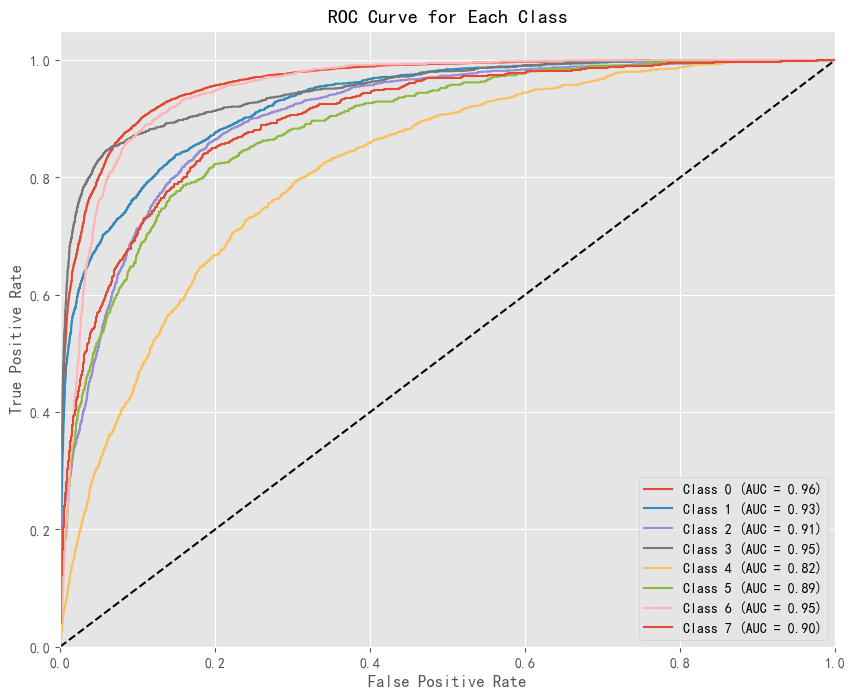

In [29]:
# 主训练循环
for epoch in range(epochs):
    training_loss, training_accuracy = train_model(model, train_loader, criterion, optimizer, device)
    print(f'Epoch: {epoch + 1}, Loss: {training_loss:.8f}, Train-Accuracy: {training_accuracy:.4f}')  # 打印轮数、损失值和准确率

# 评估模型并计算指标
all_outputs, all_labels = evaluate_model(model, test_loader, device)
compute_metrics(all_outputs, all_labels)  # 计算并打印精确率、召回率和F1分数